In [1]:
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import legwork

import sys
sys.path.append("../src/")
from variations import variations
from galaxy import simulate_mw
from seaborn_utility import cmap_from_colour
from bootstrap import bootstrapped_kde, bootstrapped_ecdf, bootstrapped_Z

In [5]:
%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [6]:
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
sim_folder = "../data/simulation/"

total_DCOs_in_MW = np.load("../data/total_DCO_in_MW.npy")
total_bound_DCOs_in_MW = np.load("../data/total_DCO_in_MW_nohubble.npy")

detections = np.load("../data/detections_4yr.npy")
detections_10yr = np.load("../data/detections_10yr.npy")

# Fiducial Simulation Analysis

## Detectable Harmonics

In [66]:
def number_of_detectable_harmonics(m_c, dist, f_orb, ecc, snr_cutoff=7, t_obs=4 * u.yr, nmax=50):
    
    # calculate the strain for each of the n harmonics and convert to signal over LISA mission
    n_range = np.arange(1, nmax).astype(int)
    hn = legwork.strain.h_0_n(m_c=m_c, dist=dist, f_orb=f_orb, n=n_range, ecc=ecc)
    signal_n_squared = t_obs * hn[:,0,:]**2

    # find the square of the noise at each of the harmonic frequency for a mission of length t_obs
    noise_n_squared = legwork.psd.lisa_psd(f=f_orb[:, np.newaxis] * n_range, t_obs=t_obs)

    # calculate the SNR as the ratio of these quantities
    snr_n_squared = (signal_n_squared / noise_n_squared).decompose()
    
    return (snr_n_squared > snr_cutoff).astype(int).sum(axis=1)

0
1
2


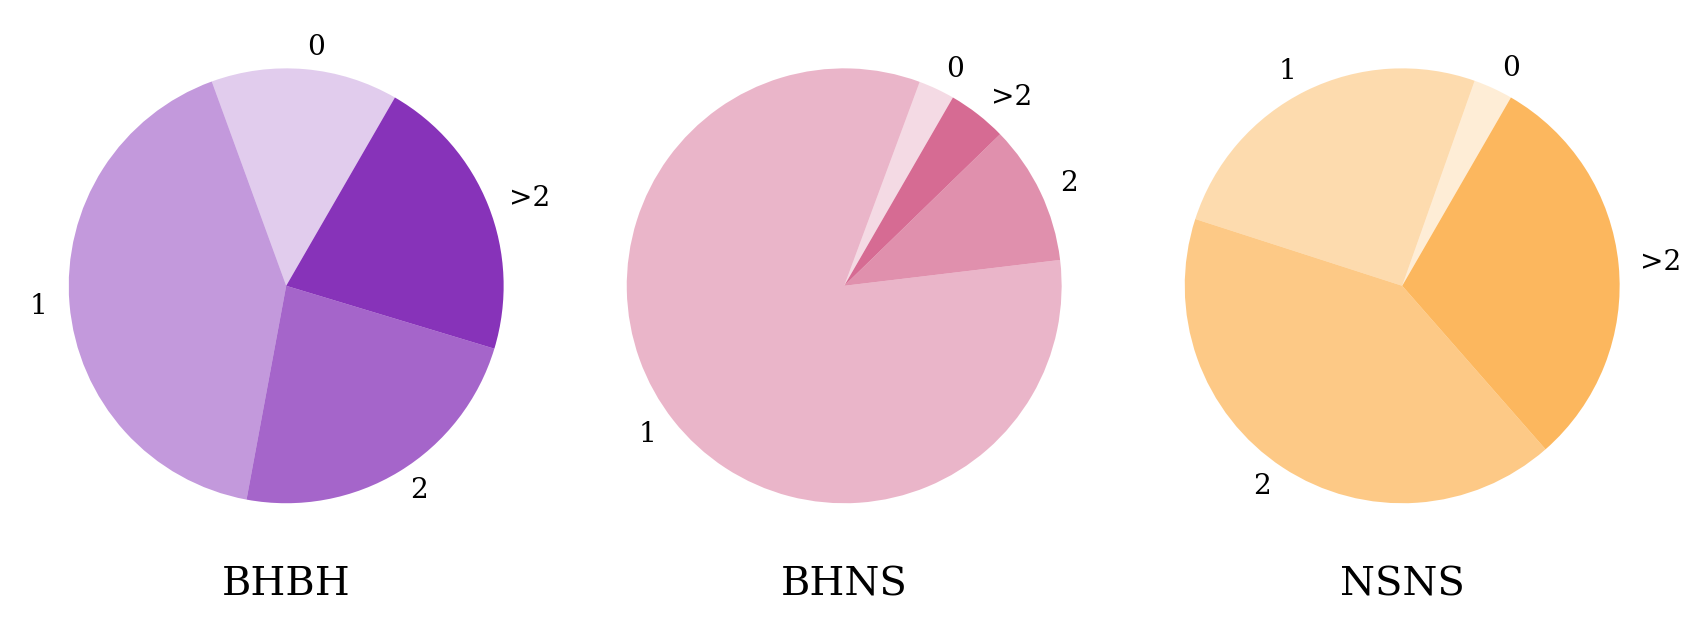

In [69]:
nharm_4yr = {"BHBH": None, "BHNS": None, "NSNS": None}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.subplots_adjust(wspace=0.0)

t_obs = 4 * u.yr

for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > 7
        data = full_data[snr_mask]
        
    m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
    f_orb_LISA = legwork.utils.get_f_orb_from_a(data["a_LISA"] * u.AU,
                                                data["m_1"] * u.Msun, data["m_2"] * u.Msun)
    
    nharm_4yr[dco_types[i]] = number_of_detectable_harmonics(m_c, data["dist"] * u.kpc, f_orb_LISA, data["e_LISA"], snr_cutoff=7 / np.sqrt(t_obs / (4 * u.yr)))
    harmonics, counts = np.unique(nharm_4yr[dco_types[i]], return_counts=True)
    sizes = [counts[0], counts[1], counts[2], counts[3:].sum()]
    labels = ["0", "1", "2", ">2"]
    colors = [dco_colours[dco_types[i]][0:3] + (0.2 * j,) for j in range(1, len(labels) + 1)]
    ax[i].pie(sizes, labels=labels, startangle=60, colors=colors)
    ax[i].set_xlabel(dco_types[i])
    print(i)

plt.show()

0
1
2


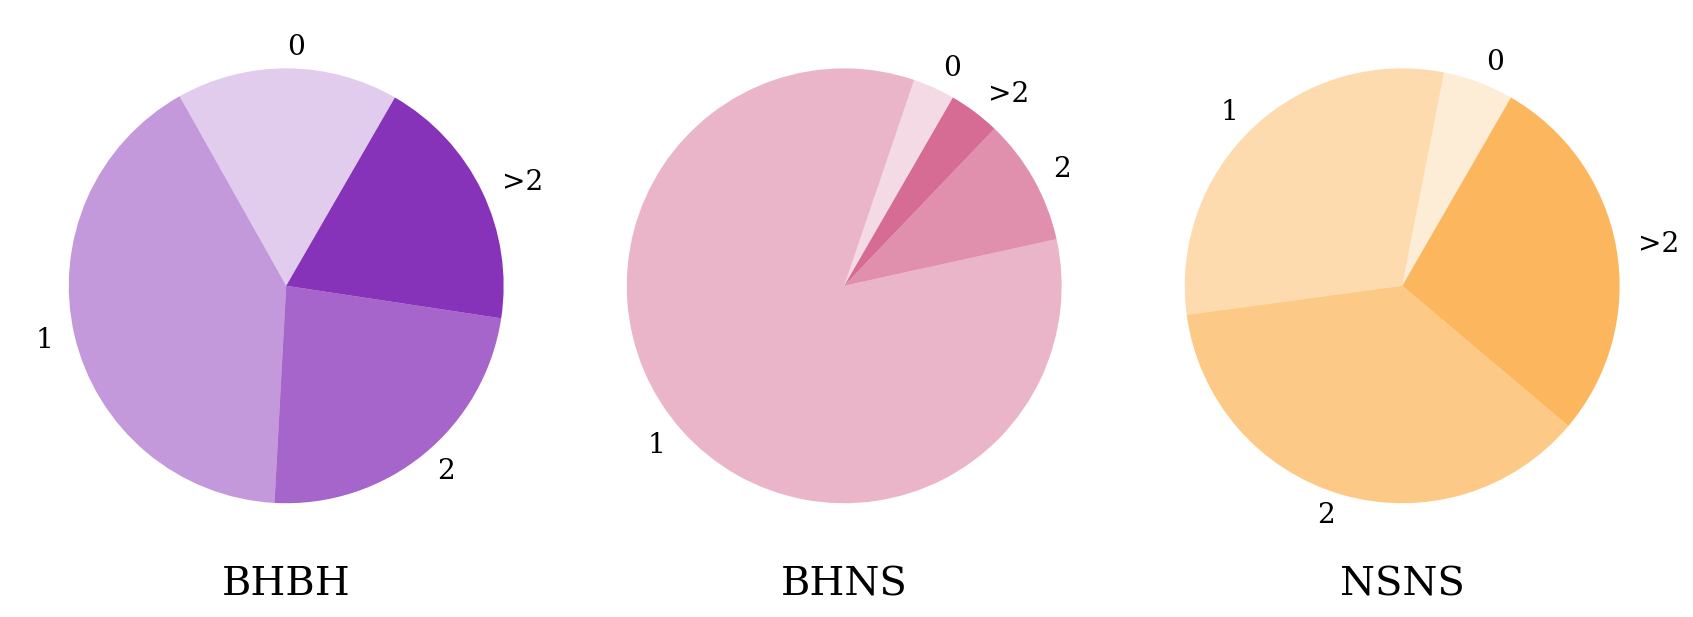

In [70]:
nharm_10yr = {"BHBH": None, "BHNS": None, "NSNS": None}

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.subplots_adjust(wspace=0.0)

t_obs = 10 * u.yr

for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * np.sqrt(t_obs / (4 * u.yr)) > 7
        data = full_data[snr_mask]
        
    m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
    f_orb_LISA = legwork.utils.get_f_orb_from_a(data["a_LISA"] * u.AU,
                                                data["m_1"] * u.Msun, data["m_2"] * u.Msun)
    
    nharm_10yr[dco_types[i]] = number_of_detectable_harmonics(m_c, data["dist"] * u.kpc, f_orb_LISA, data["e_LISA"], snr_cutoff=7 / np.sqrt(t_obs / (4 * u.yr)))
    harmonics, counts = np.unique(nharm_10yr[dco_types[i]], return_counts=True)
    sizes = [counts[0], counts[1], counts[2], counts[3:].sum()]
    labels = ["0", "1", "2", ">2"]
    colors = [dco_colours[dco_types[i]][0:3] + (0.2 * j,) for j in range(1, len(labels) + 1)]
    ax[i].pie(sizes, labels=labels, startangle=60, colors=colors)
    ax[i].set_xlabel(dco_types[i])
    print(i)

plt.show()

## Parameter distributions

In [71]:
def sky_localisation(snr, fGW, L=2*u.AU):
    sigma_theta = 16.6 * (7 / snr) * (5e-4 * u.Hz / fGW) * (2 * u.AU / L) * u.deg
    return sigma_theta.to(u.deg)

def f_uncertainty(snr, t_obs, f):
    return (4 * np.sqrt(3) / np.pi / (snr * t_obs) / f).decompose()

def fdot_uncertainty(snr, t_obs, fdot):
    return (6 * np.sqrt(5) / np.pi / (snr * t_obs**2) / fdot).decompose()

def Fprime_over_F(e):
    return e * (1256 + 1608 * e**2 + 111 * e**4) / (96 + 196 * e**2 - 255 * e**4 - 37 * e**6)

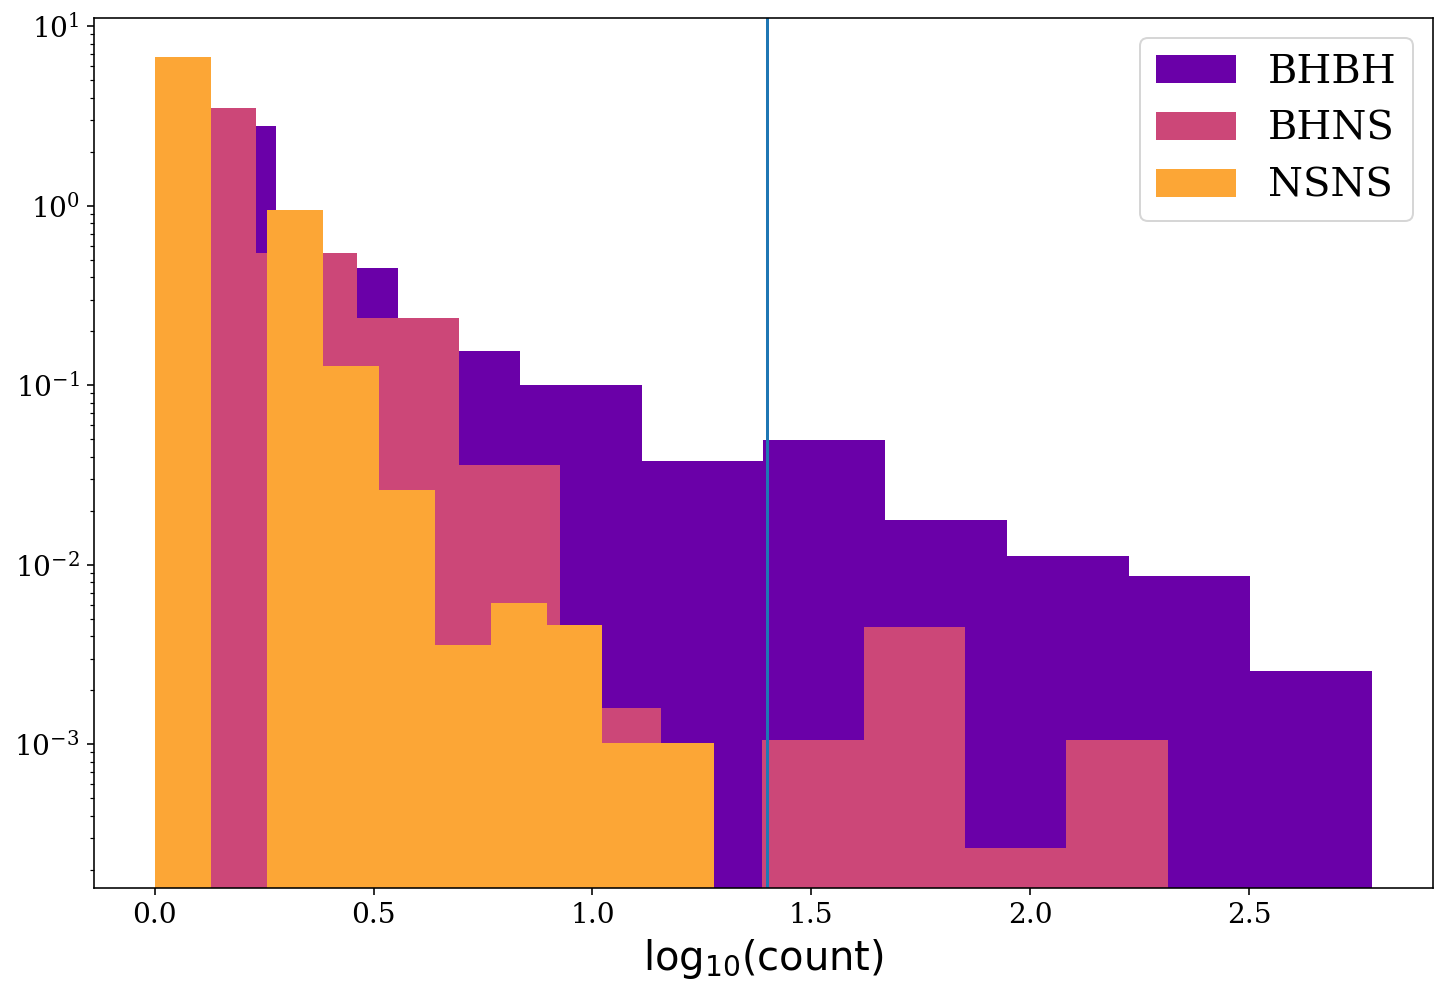

In [214]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    uniques, counts = np.unique(data["seed"], return_counts=True)
    
    plt.hist(np.log10(counts), density=True, log=True, color=dco_colours[dco_type], label=dco_type)

plt.legend()

plt.xlabel(r"$\log_{10} (\rm count)$")

plt.axvline(np.log10(25))

plt.show()

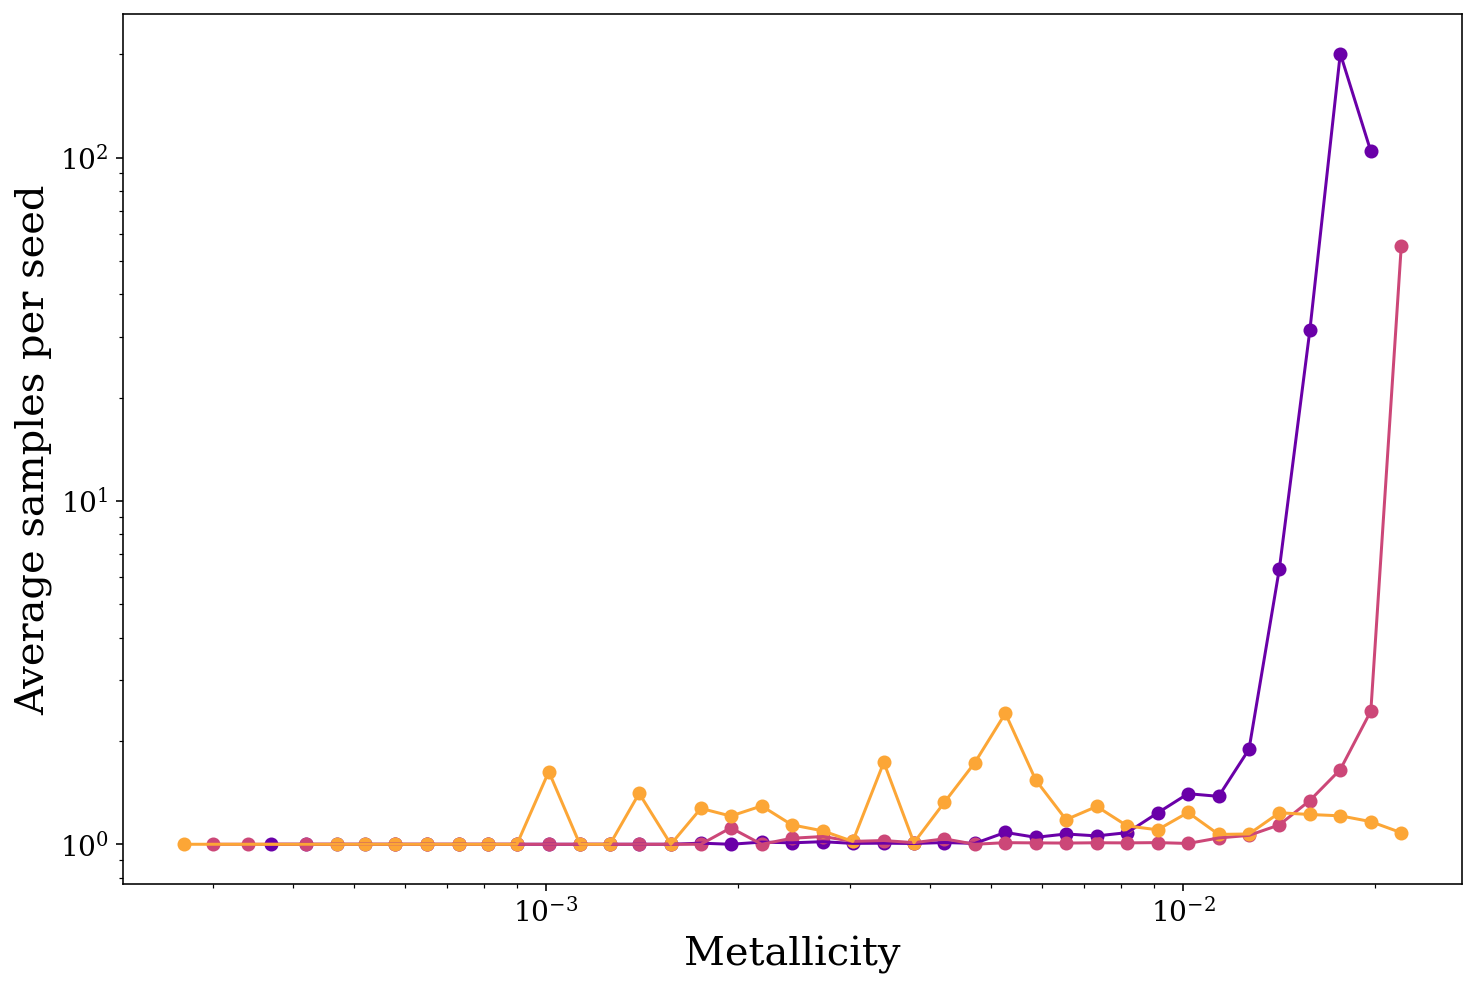

In [291]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    uniques, ind, counts = np.unique(data["seed"], return_index=True, return_counts=True)
    
#     plt.scatter(data["Z"][ind], counts, color=dco_colours[dco_type])
    
    unique_Z = np.unique(data["Z"])
    means = np.zeros(len(unique_Z))
    for i, Z in enumerate(unique_Z):
        mask = data["Z"][ind] == Z
        means[i] = np.average(counts[mask], weights=data["weight"][ind][mask])
#         plt.scatter(Z, counts[mask].min(), color=dco_colours[dco_type], marker="^")
#         plt.scatter(Z, counts[mask].max(), color=dco_colours[dco_type], marker="v")
    plt.scatter(unique_Z, means, color=dco_colours[dco_type])
    plt.plot(unique_Z, means, color=dco_colours[dco_type])
    
#     plt.hist(np.log10(counts), density=True, log=True, color=dco_colours[dco_type], label=dco_type)

# plt.legend()

# plt.xlabel(r"$\log_{10} (\rm count)$")

# plt.axvline(np.log10(25))

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Metallicity")
plt.ylabel("Average samples per seed")

plt.show()

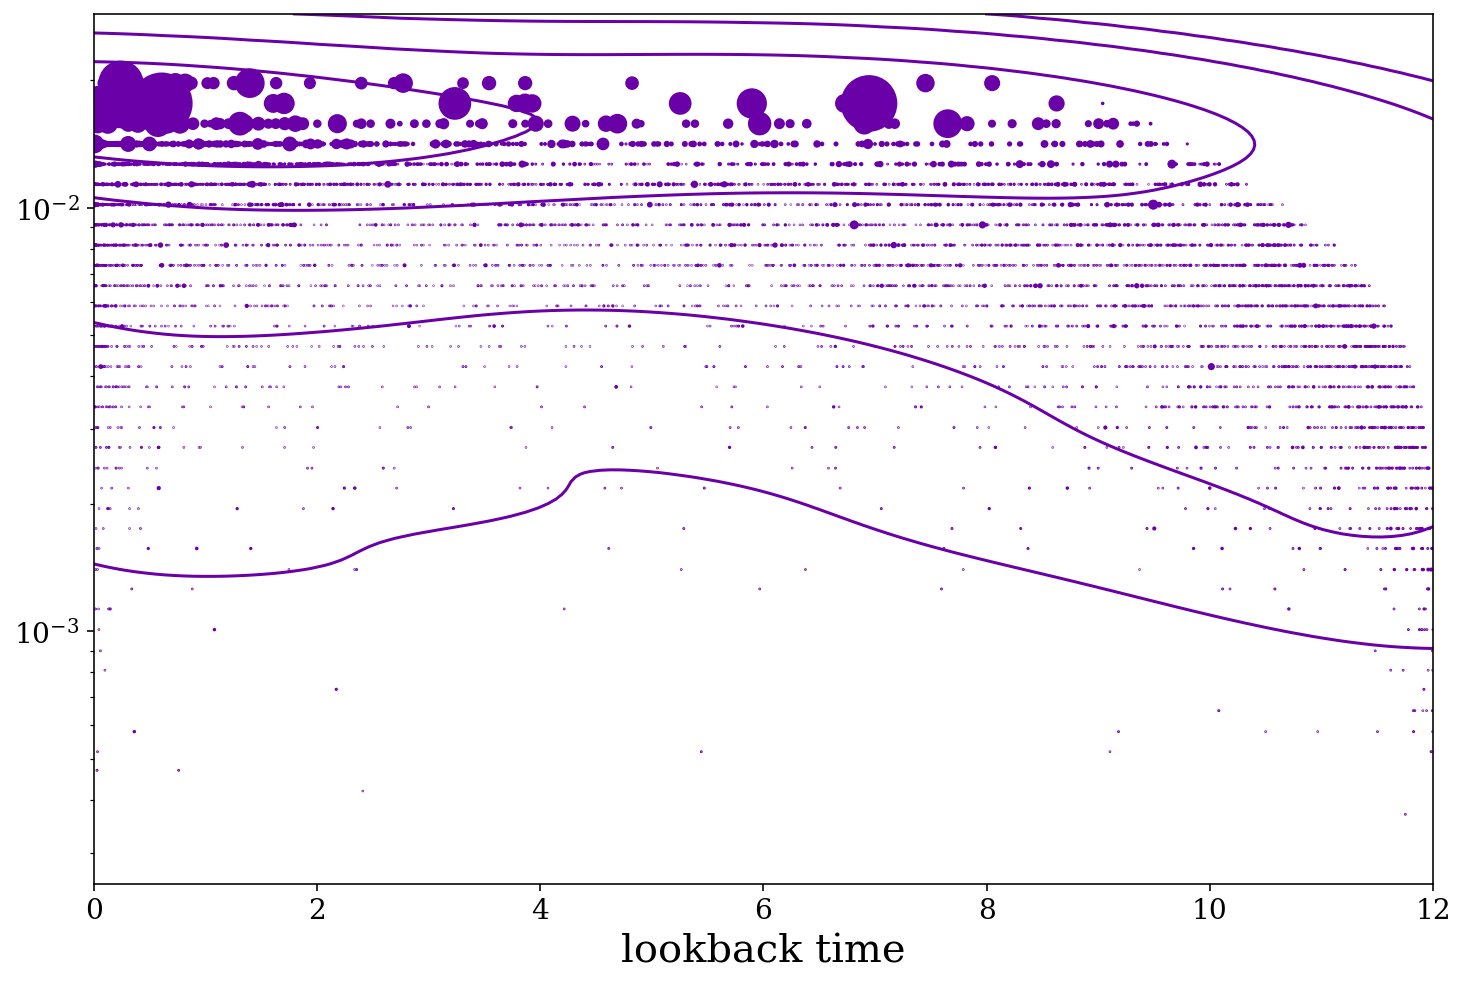

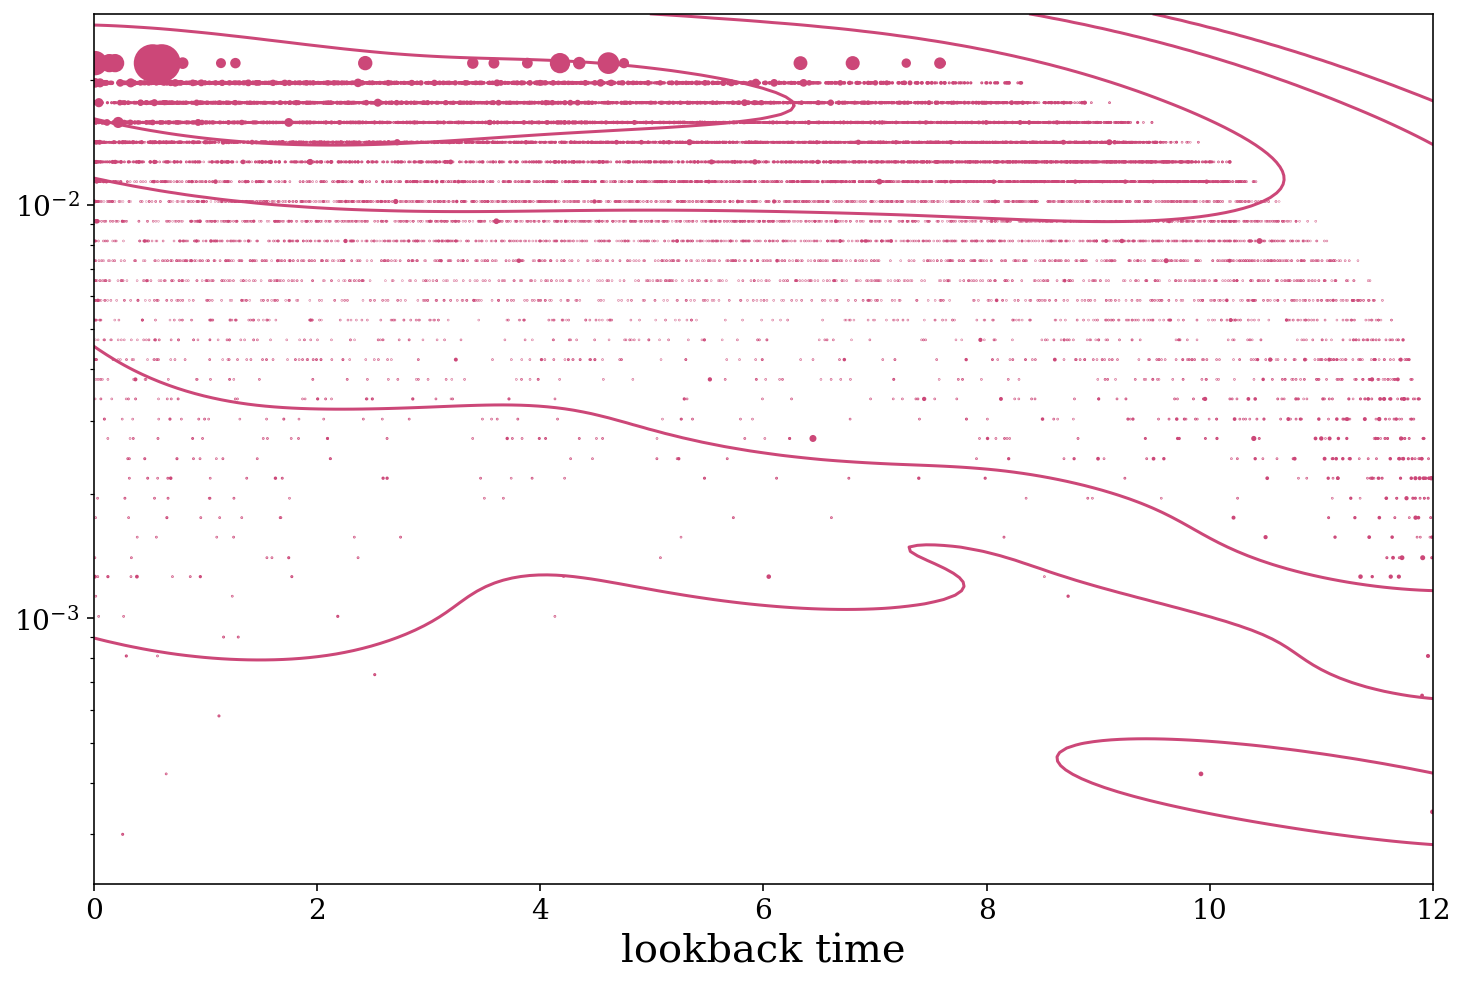

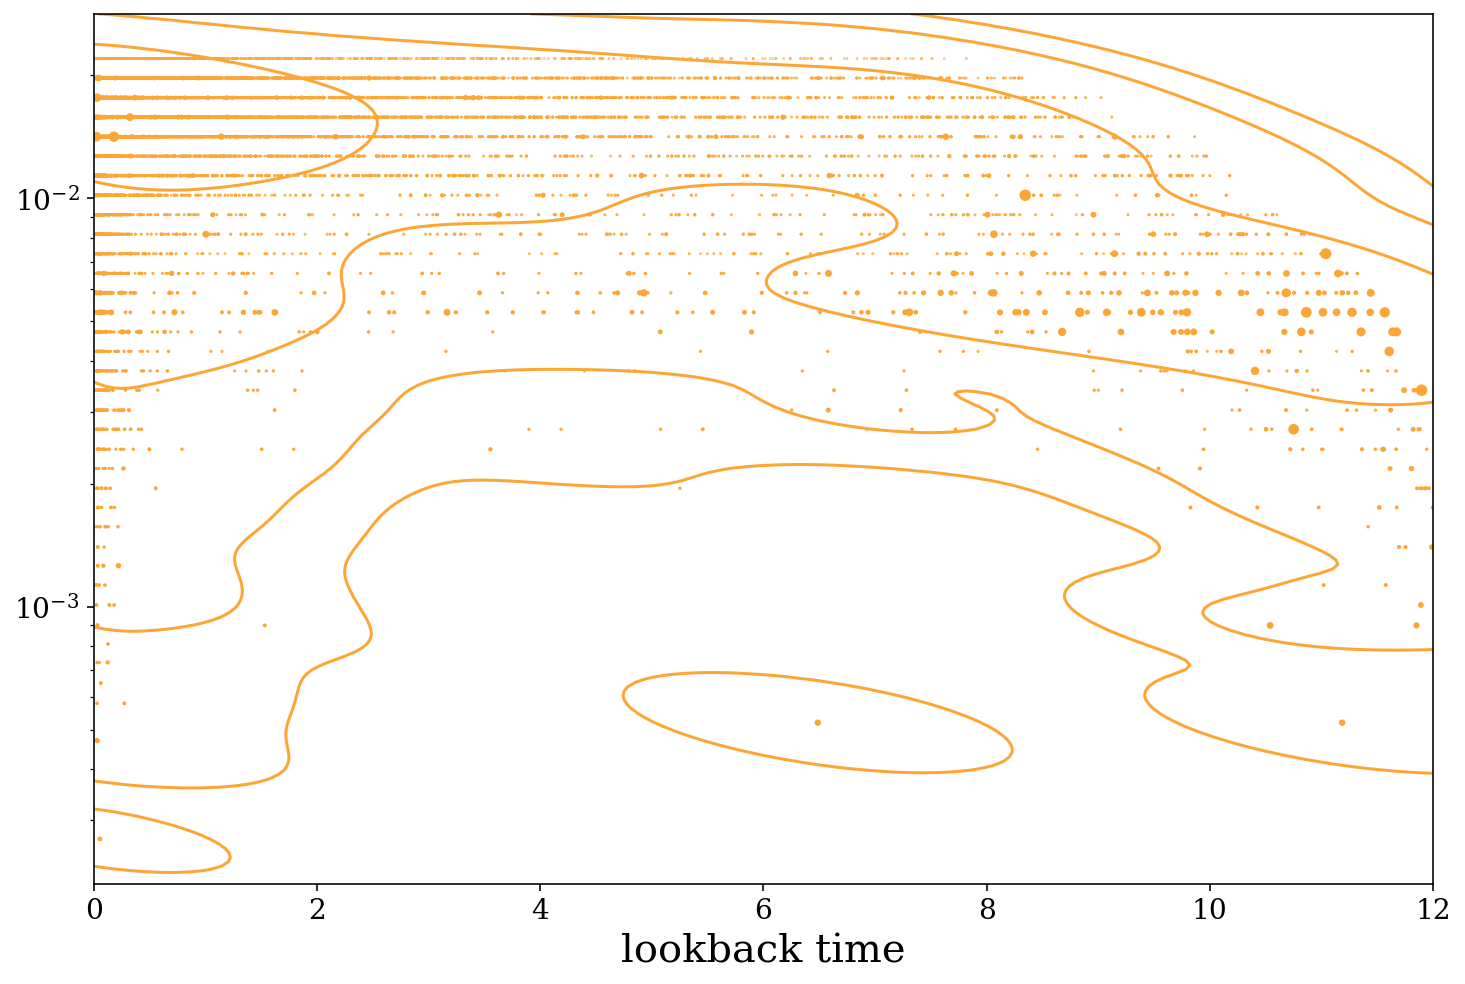

In [259]:
t_obs = 4 * u.yr
for dco_type in ["BHBH", "BHNS", "NSNS"]:
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        
    # make everything unique and adjust weights
    _, uni_index, uni_count = np.unique(data["seed"],
                                        return_index=True, return_counts=True)
    data = data[uni_index]
    data["weight"] *= uni_count
        
    plt.scatter(data["tau"], data["Z"], s=data["weight"] * 10, color=dco_colours[dco_type])
    sns.kdeplot(x=data["tau"], y=data["Z"], weights=data["weight"], color=dco_colours[dco_type],
                log_scale=(False, True), levels=[0.001, 0.01, 0.1, 0.5])

    plt.xlabel("lookback time")
    plt.xlim(0, 12)
#     plt.yscale("log")
    plt.show()

In [241]:
model = 0
for i, dco_type in enumerate(["BHBH", "BHNS", "NSNS"]):
    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

        data = full_data[snr_mask]
        count_mask = np.repeat(True, len(data))
        data = data[count_mask]
        
    print(np.min(data["m_1"]))
    print(np.min(data["m_2"]))
    print()

3.85833
2.67215

1.27758
1.27758

1.26
1.27758



In [244]:
def grid_plot(model=0, t_obs=10 * u.yr, unique=False, count_limit=np.inf):
    fig, axes = plt.subplots(3, 3, figsize=(22, 15))

    plt.subplots_adjust(top=0.97, hspace=0.25)
    
    lw = 4

    Z_vals = np.concatenate((np.logspace(-4, np.log10(0.022), 50).round(5), [0.0244,  0.02705, 0.03]))
    inner_bins = np.array([Z_vals[i]
                           + (Z_vals[i+1] - Z_vals[i])
                           / 2 for i in range(len(Z_vals) - 1)])
    Z_bins = np.concatenate(([Z_vals[0]], inner_bins,
                             [Z_vals[-1]]))
    
    for i, dco_type in enumerate(["BHBH", "BHNS", "NSNS"]):
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] * (t_obs / (4 * u.yr))**(0.5) > 7

            data = full_data[snr_mask]
            if unique:
                _, places = np.unique(data["seed"], return_index=True)
                data = data[places]
            
            if count_limit != np.inf:
                unique_seeds, counts = np.unique(data["seed"], return_counts=True)
                count_mask = np.isin(data["seed"], unique_seeds[counts < count_limit])
                print(np.all(count_mask))
            else:
                count_mask = np.repeat(True, len(data))
            data = data[count_mask]
            
        detection_total = detections if t_obs == 4 * u.yr else detections_10yr

        m_c = legwork.utils.chirp_mass(data["m_1"], data["m_2"]) * u.Msun
        f_orb_LISA = legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                              a=data["a_LISA"] * u.AU)
        f_dot = legwork.utils.fn_dot(m_c=m_c, f_orb=f_orb_LISA, e=data["e_LISA"], n=1)
        sigma_theta = sky_localisation(data["snr"], f_orb_LISA * 2).to(u.deg)
        
        t_merge = legwork.evol.get_t_merge_ecc(ecc_i=data["e_DCO"], a_i=data["a_DCO"] * u.AU,
                                          m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun).to(u.Gyr)

        D_fdot = fdot_uncertainty(data["snr"] , t_obs, f_dot)
        D_f = f_uncertainty(data["snr"], t_obs, f_orb_LISA)
        
        if t_obs == 4 * u.yr:
            D_e = np.where(nharm_4yr[dco_type] > 1, 0.05, np.where(nharm_4yr[dco_type] == 0, 1, 0.1))[count_mask]
        else:
            D_e = np.where(nharm_10yr[dco_type] > 1, 0.05, np.where(nharm_10yr[dco_type] == 0, 1, 0.1))[count_mask]
        D_Mc = 11 / 5 * D_f + 3 / 5 * D_fdot + 3 / 5 * Fprime_over_F(data["e_LISA"]) * D_e

        localised = sigma_theta <= np.sqrt(0.67 / np.pi) * u.deg
        distinguished = D_Mc <= 0.1
        print(variations[model]["med"])
        print(dco_type, len(data["m_1"]))
        print("\tDetections {:1.2f}".format(detection_total[i][model].mean()))
        print("\tLocalised detections {:1.2f}".format(detection_total[i][model].mean()
                                                      * len(data[localised]) / len(data)))
        print("\tDistinguished detections {:1.2f}".format(detection_total[i][model].mean()
                                                          * len(data[distinguished]) / len(data)))
        print("\tLocalised AND distinguished detections {:1.2f}".format(detection_total[i][model].mean()
                                                                        * len(data[np.logical_and(localised, distinguished)]) / len(data)))

        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mNS = np.minimum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
            mass_seeds = data["seed"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
        elif dco_type == "NSNS":
            mNS = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))
            
        if dco_type in ["BHNS", "BHBH"]:
            axes[0, 0] = bootstrapped_kde(mBH, mass_weights, mass_seeds, bw_adjust=1.4,
                                  ax=axes[0, 0], color=dco_colours[dco_type], label=dco_type)
            axes[0, 0].set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
            axes[0, 0].set_xlim(2.6, 21)

        if dco_type in ["BHNS", "NSNS"]:
            axes[0, 1] = bootstrapped_kde(mNS, mass_weights, mass_seeds, bw_adjust=0.8, log_scale=(False, True),
                                          ax=axes[0, 1], color=dco_colours[dco_type], label=dco_type)
            axes[0, 1].set_xlabel(r"Neutron Star Mass, $m_{\rm NS} \, [\rm M_{\odot}]$")
            axes[0, 1].set_xlim(1.26, 2.5)
        
        axes[0, 2] = bootstrapped_kde(np.log10(f_orb_LISA.value), data["weight"], data["seed"],
                                      ax=axes[0, 2], color=dco_colours[dco_type], label=dco_type)
        axes[0, 2].set_xlabel(r"Orbital Frequency, $f_{\rm orb, LISA} /, [{\rm Hz}]$")
        axes[0, 2].set_xlim(-5.1, -2.1)

        axes[1, 0] = bootstrapped_kde(data["dist"], data["weight"], data["seed"],
                                      ax=axes[1, 0], color=dco_colours[dco_type], label=dco_type)
        axes[1, 0].set_xlabel(r"Luminosity Distance, $D_{\rm L} \, [\rm kpc]$")
        axes[1, 0].set_xlim(0, 25)
        axes[1, 0].axvline(8.2, color="grey", linestyle="dotted", zorder=0)
        axes[1, 0].annotate("Milky Way Centre", xy=(8.2, 0.04), color="grey", rotation=90, ha="center", va="center",
                            bbox=dict(boxstyle="round", ec="white", fc="white"), fontsize=0.55*fs)
        
        axes[1, 1] = bootstrapped_kde(data["tau"], data["weight"], data["seed"],
                                      ax=axes[1, 1], color=dco_colours[dco_type], label=dco_type)
        axes[1, 1].set_xlabel(r"Lookback Time, $\tau \, [\rm Gyr]$")
        axes[1, 1].set_xlim(0, 12)
        
        axes[1, 2] = bootstrapped_Z(data["Z"], weights=data["weight"], seeds=data["seed"], ax=axes[1, 2],
                                    color=dco_colours[dco_type], label=dco_type)    
        axes[1, 2].set_xscale("log")
        axes[1, 2].set_yscale("log")
        axes[1, 2].set_xlim(3e-4, 0.024)
        axes[1, 2].set_xlabel(r"Metallicity, $Z$")
        
        axes[2, 0] = bootstrapped_ecdf(D_Mc.value, weights=data["weight"], seeds=data["seed"],
                                       normalisation=detections[i, model].mean(), ax=axes[2, 0],
                                       log_scale=(True, False), color=dco_colours[dco_type], label=dco_type)
        axes[2, 0].set_xlabel(r"Chirp Mass Error, $\log_{10}(\Delta \mathcal{M}_c / \mathcal{M}_c)$")
        axes[2, 0].set_xlim(9e-5, 2e3)
        axes[2, 0].axvspan(1.0, axes[2, 0].get_xlim()[1], color="grey", zorder=10, alpha=0.2)

        axes[2, 1] = bootstrapped_ecdf(data["e_LISA"], weights=data["weight"], seeds=data["seed"],
                                       normalisation=detections[i, model].mean(), ax=axes[2, 1],
                                       log_scale=(True, False), color=dco_colours[dco_type], label=dco_type)
        axes[2, 1].set_xlabel(r"Eccentricity, $\log_{10}(e_{\rm LISA})$")
        axes[2, 1].set_xlim(2e-4, 1.0)
        axes[2, 1].axvspan(axes[2, 1].get_xlim()[0], 1e-2, color="grey", zorder=10, alpha=0.2)
        
        axes[2, 2] = bootstrapped_ecdf(sigma_theta.value, weights=data["weight"], seeds=data["seed"],
                                       normalisation=detections[i, model].mean(), ax=axes[2, 2],
                                       log_scale=(True, False), color=dco_colours[dco_type], label=dco_type)
        axes[2, 2].set_xlabel(r"Angular Resolution, $\log_{10}(\sigma_{\theta} / {\rm ^\circ})$")
        axes[2, 2].set_xlim(5e-3, 1e3)
        
        telescopes = [("SKA", 0.67 * u.deg**2), ("JWST NIRCam", 9.7 * u.arcmin**2), ("GOTO-Present", 40 * u.deg**2), ("GOTO-2022", 160 * u.deg**2), ("Swift", (23.6 * u.arcmin)**2)]
        
        for name, area in telescopes:
            angular_resolution = np.sqrt(area / np.pi).to(u.deg)
            axes[2, 2].axvline(angular_resolution.value, linestyle="dotted", color="grey")
            
            y = detections_10yr[:, 0].mean(axis=1).max() if t_obs == 10 * u.yr else detections[:, 0].mean(axis=1).max()
            va = "top"
            axes[2, 2].annotate(name, xy=(angular_resolution.value, y), xycoords="data", rotation=90,
                             ha="center", va=va, fontsize=0.5*fs, color="grey", bbox=dict(boxstyle="round", fc="white", ec="white"))
        
    tau, D, Z = simulate_mw(int(1e6))
    sns.kdeplot(D, ax=axes[1, 0], color="grey", bw_adjust=1.5, linestyle="dotted", cut=0)
    
    for Z in Z_vals:
        axes[1, 2].axvline(Z, zorder=-2, color="grey", linestyle="dotted", lw=0.5)
    
    handles, labels = axes[0, 2].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', fontsize=fs, ncol=3, borderaxespad=0.0)

    for ax in axes.flatten():
        ax.tick_params(labelsize=0.7*fs)
#         ax.set_yticks([])
        ax.set_ylabel("")
        ax.xaxis.label.set_fontsize(fs)
        
    axes[0, 0].set_ylabel("PDF")
    axes[1, 0].set_ylabel("PDF")
    axes[2, 0].set_ylabel("Cumulative detections")

    if t_obs == 4 * u.yr:
        plt.savefig("../../paper/figures/distribution_grid_4yr.pdf", format="pdf", bbox_inches="tight")
    else:
        plt.savefig("../../paper/figures/distribution_grid_10yr.pdf", format="pdf", bbox_inches="tight")

    plt.show()

fiducial
BHBH 26154
	Detections 39.58
	Localised detections 1.61
	Distinguished detections 2.58
	Localised AND distinguished detections 1.47
2.67215
2.67215
-6.5266125974746965
0.03557551261871997
0.00066005315274964
fiducial
BHNS 23015
	Detections 36.47
	Localised detections 2.76
	Distinguished detections 4.19
	Localised AND distinguished detections 2.72
2.67392
2.67392
1.27758
-6.285404381055521
0.08576574479797294
0.0001643820729189116
fiducial
NSNS 18039
	Detections 8.73
	Localised detections 1.19
	Distinguished detections 1.35
	Localised AND distinguished detections 1.16
1.26
-6.03555919436031
0.04214026534112879
0.00019719556821051754


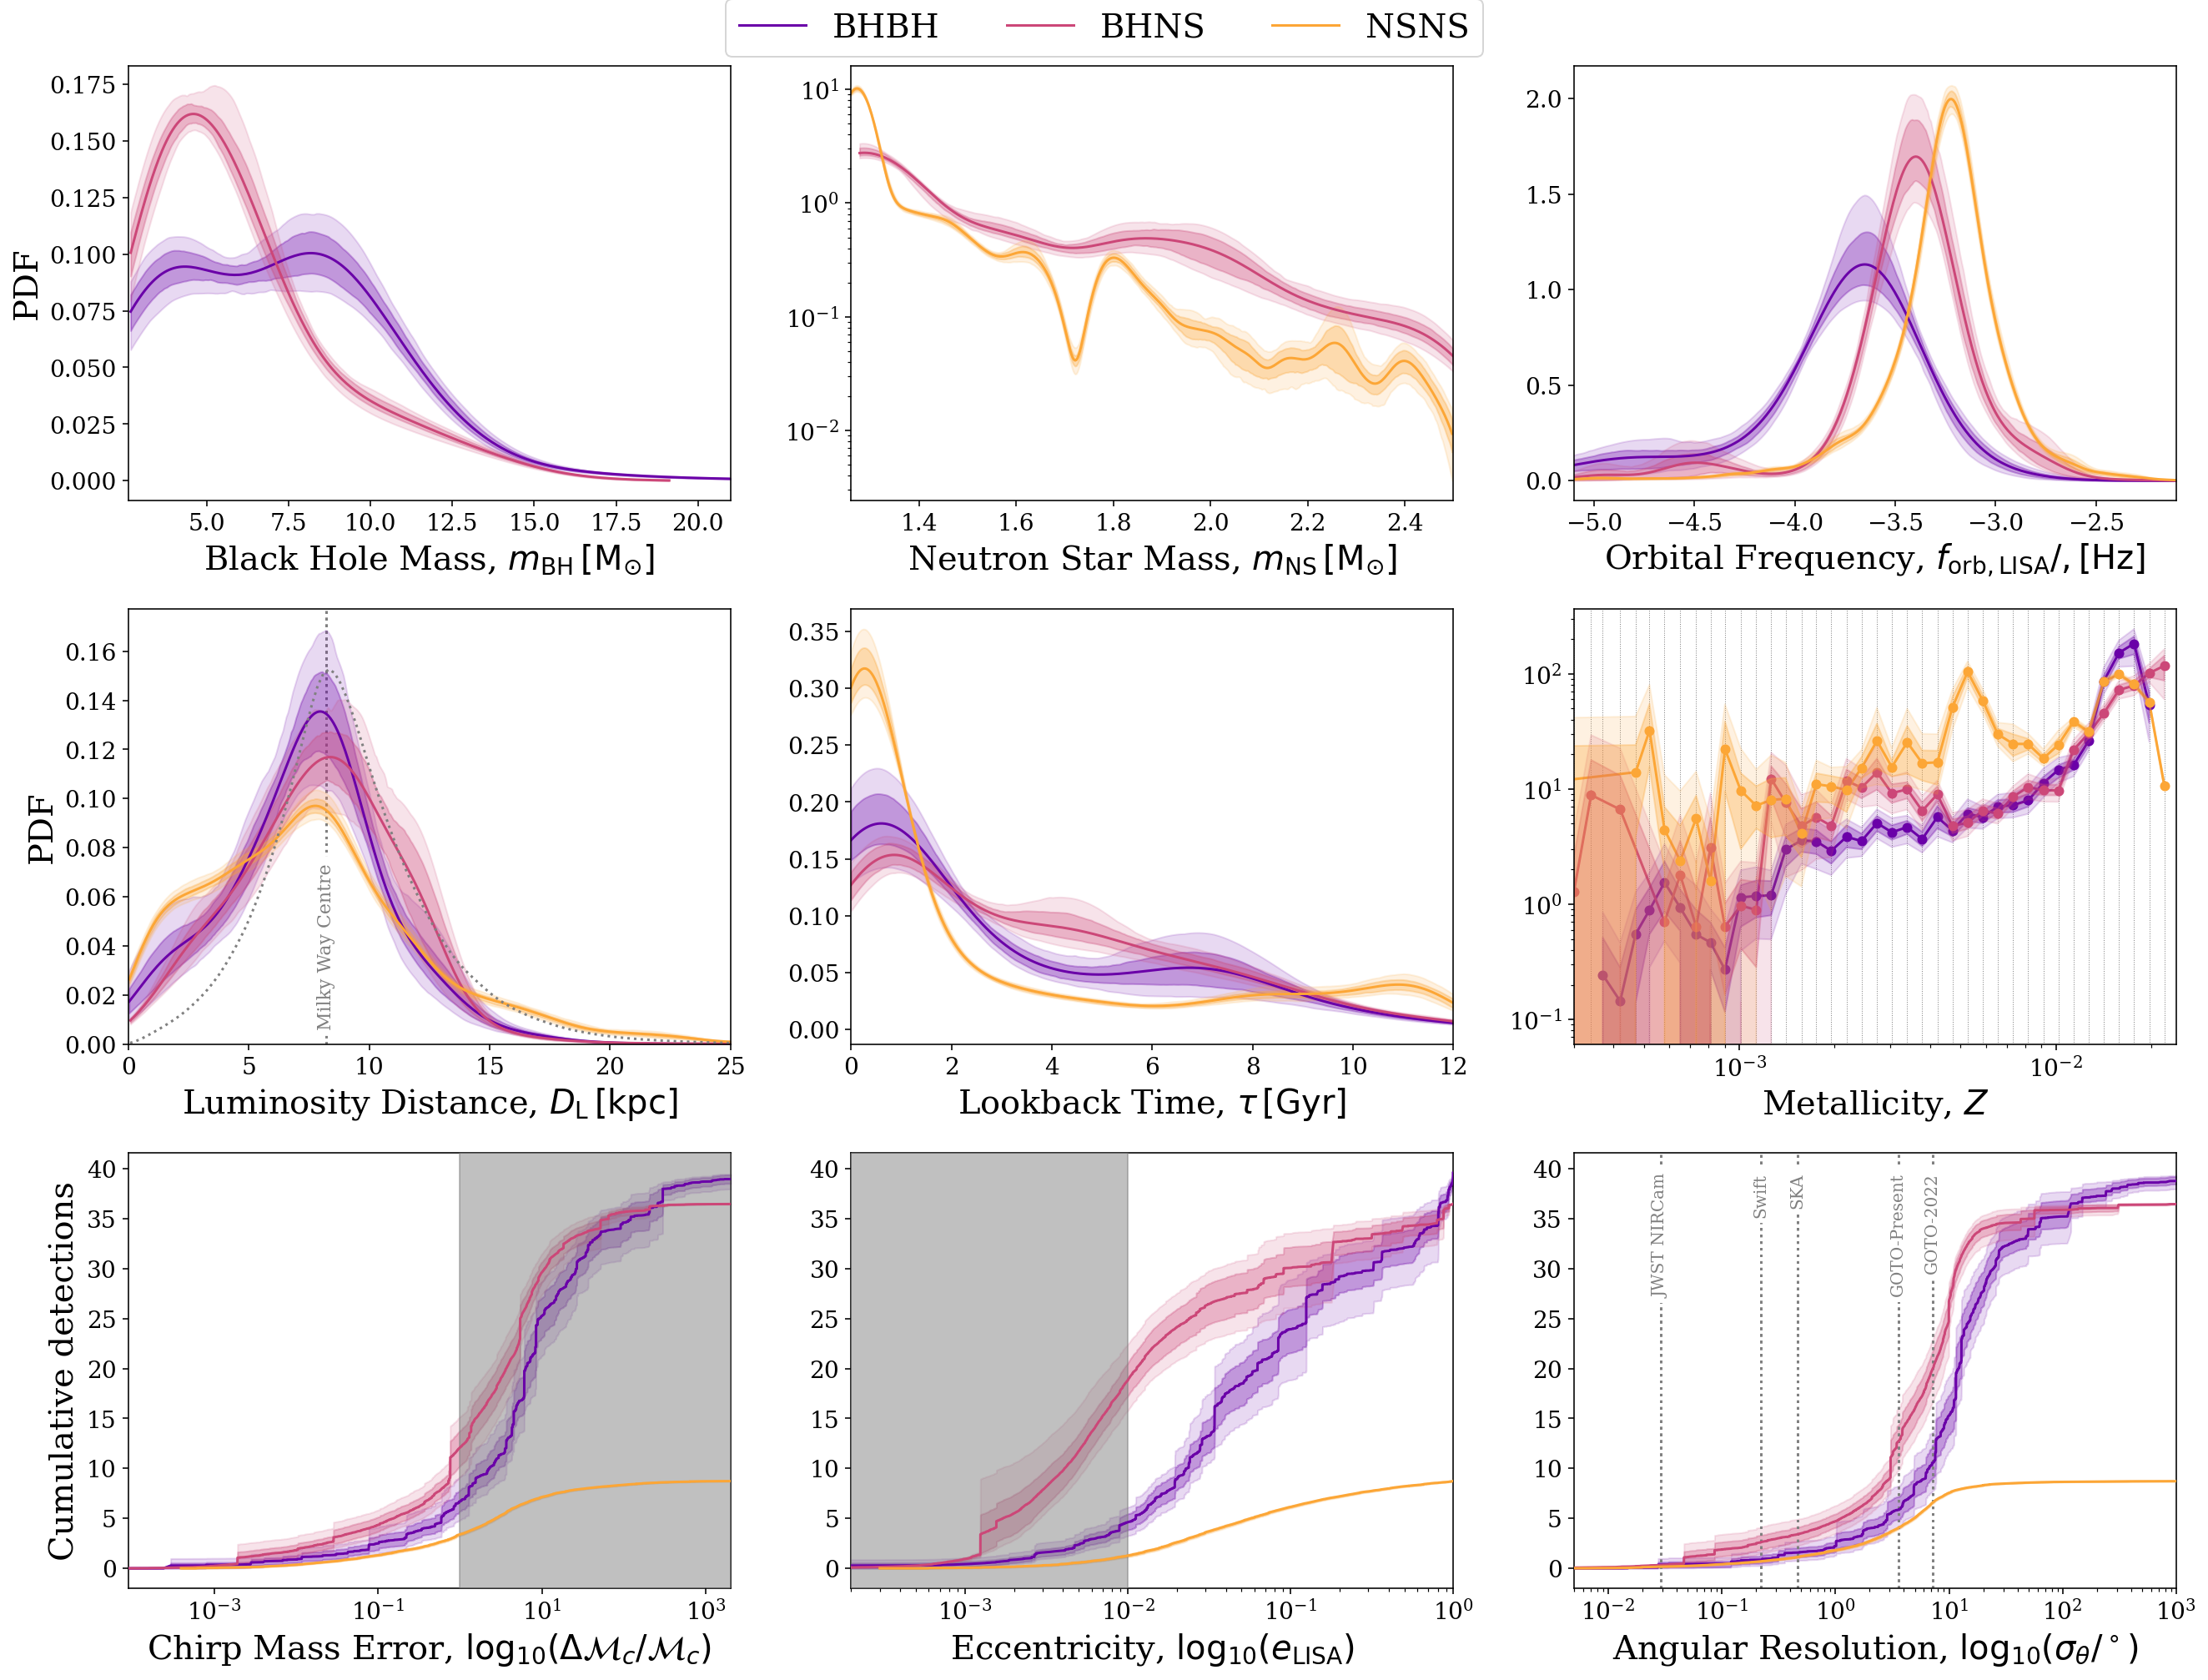

In [245]:
grid_plot(t_obs=4 * u.yr)

In [31]:
def kdeplot_something(variable, dco_type_list=["BHBH", "BHNS", "NSNS"], variation_index=0,
                      fig=None, ax=None, show=True, count_limit=np.inf, channel=None, **kwargs):
    if fig is None or ax is None:   
        fig, ax = plt.subplots(1, figsize=(10, 5))

    for dco_type in dco_type_list:
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[variation_index]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            snr_mask = full_data["snr"] > 7

            data = full_data[snr_mask]
            
            unique_seeds, counts = np.unique(data["seed"], return_counts=True)
            count_mask = np.isin(data["seed"], unique_seeds[counts < count_limit])
            
            data = data[count_mask]
            if channel is not None:
                data = data[np.isin(data["channel"], channel)]

        sns.kdeplot(data[variable], weights=data["weight"], color=dco_colours[dco_type], cut=0, lw=4, **kwargs)

    if show:
        plt.show()
    return fig, ax

## Bootstrap errors on KDEs

In [118]:
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from statsmodels.nonparametric.kde import KDEUnivariate

In [5]:
import time

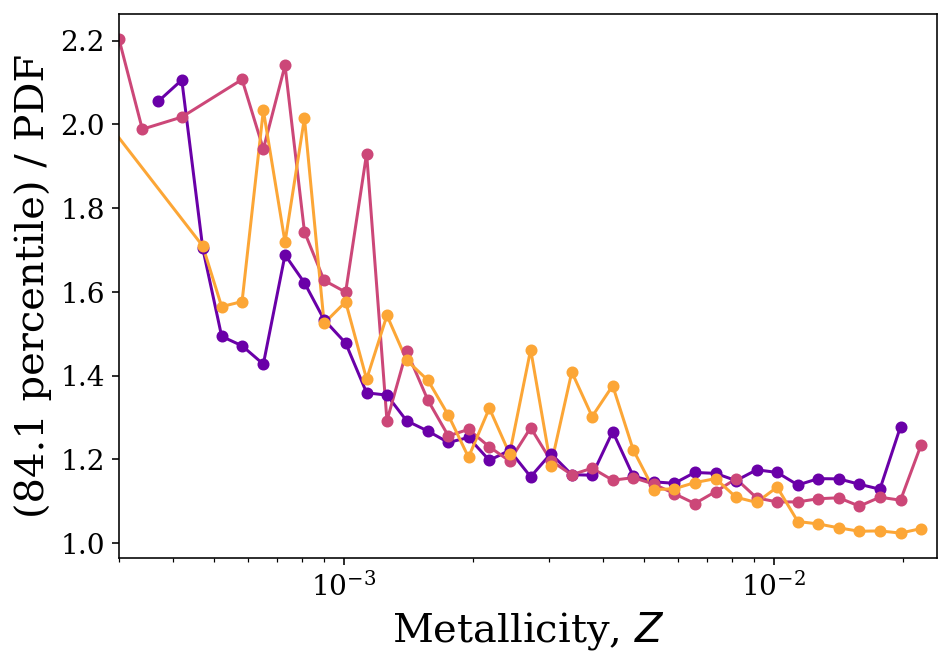

In [308]:
fig, ax = plt.subplots(figsize=(7.333, 5))



for dco_type in dco_types:

    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7

        data = full_data[snr_mask]

        unique_seeds, counts = np.unique(data["seed"], return_counts=True)
        count_mask = np.isin(data["seed"], unique_seeds[counts < np.inf])

        data = data[count_mask]
        
    Z = data["Z"]
    weights = data["weight"]
    seeds = data["seed"]
    color = dco_colours[dco_type]
    bootstraps = 200
        
    # work metallicity bins
    Z_vals = np.concatenate((np.logspace(-4, np.log10(0.022), 50).round(5),
                             [0.0244,  0.02705, 0.03]))
    inner_bins = np.array([Z_vals[i]
                           + (Z_vals[i+1] - Z_vals[i])
                           / 2 for i in range(len(Z_vals) - 1)])
    Z_bins = np.concatenate(([Z_vals[0]], inner_bins,
                             [Z_vals[-1]]))

    # make everything unique and adjust weights
    _, uni_index, uni_count = np.unique(seeds,
                                        return_index=True, return_counts=True)
    Z = Z[uni_index]
    weights = weights[uni_index] * uni_count

    indices = np.arange(len(Z))
    hist_vals = np.zeros((bootstraps, len(Z_vals)))
    for i in range(len(hist_vals)):

        boot_index = np.random.choice(indices, size=len(indices), replace=True)

        hist_vals[i], _ = np.histogram(Z[boot_index], bins=Z_bins,
                                       weights=weights[boot_index],
                                       density=True)

    hist, _ = np.histogram(Z, bins=Z_bins, weights=weights, density=True)
    nonzero = hist > 0

    # calculate 1- and 2- sigma percentiles
    percentiles = np.percentile(hist_vals, [15.89, 84.1, 2.27, 97.725], axis=0)
    
    ratio = percentiles[1][nonzero] / hist[nonzero]
    ax.plot(Z_vals[nonzero], ratio, color=color,
            zorder=-1)
    ax.scatter(Z_vals[nonzero], ratio, s=25, color=color)

    # plot uncertainties as filled areas
#     ax.fill_between(Z_vals[nonzero], percentiles[2][nonzero],
#                     percentiles[3][nonzero], alpha=0.15, color=color)
#     ax.fill_between(Z_vals[nonzero], percentiles[0][nonzero],
#                     percentiles[1][nonzero], alpha=0.3, color=color)

#     ax.plot(Z_vals[nonzero], hist[nonzero], color=color,
#             zorder=-1)
#     ax.scatter(Z_vals[nonzero], hist[nonzero], s=25, color=color)

ax.set_ylabel("(84.1 percentile) / PDF")

ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlim(3e-4, 0.024)
ax.set_xlabel(r"Metallicity, $Z$")
plt.show()

## Sensitivity Curve plots

In [21]:
fid_sources = [None, None, None]
for i in range(len(dco_types)):
    with h5.File(sim_folder + "{}_fiducial_all.h5".format(dco_types[i]), "r") as f:
        full_data = f["simulation"][...].squeeze()
        snr_mask = full_data["snr"] > 7
        
        data = full_data[snr_mask]
        
    # make everything unique and adjust weights
    _, uni_index, uni_count = np.unique(data["seed"],
                                        return_index=True, return_counts=True)
    data = data[uni_index]
    data["weight"] *= uni_count
        
    fid_sources[i] = legwork.source.Source(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun,
                                                dist=data["dist"] * u.kpc, ecc=data["e_LISA"],
                                                a=data["a_LISA"] * u.AU)
    fid_sources[i].weight = data["weight"]

In [22]:
for i in range(len(dco_types)):
    fid_sources[i].get_snr(verbose=True)

Calculating SNR for 7063 sources
	7061 sources are stationary
		6011 sources are stationary and circular
		1050 sources are stationary and eccentric
	2 sources are evolving
		2 sources are evolving and circular
Calculating SNR for 16381 sources
	16379 sources are stationary
		15766 sources are stationary and circular
		613 sources are stationary and eccentric
	2 sources are evolving
		2 sources are evolving and circular
Calculating SNR for 15314 sources
	15312 sources are stationary
		8929 sources are stationary and circular
		6383 sources are stationary and eccentric
	2 sources are evolving
		2 sources are evolving and circular


In [28]:
def plot_sc_with_dist_lines(frequency_range, fig, ax, mc_mean, mc_min, line_scale=1, line_rot=10, loc=-50):
    legwork.visualisation.plot_sensitivity_curve(show=False, frequency_range=frequency_range, fig=fig, ax=ax)
    
    times = np.logspace(0, -8, 9) * u.Gyr
    athings = np.power(4 * legwork.utils.beta(mc_min * 2**(1/5), mc_min * 2**(1/5)) * times, 1/4)
    freqs = legwork.utils.get_f_orb_from_a(a=athings, m_1=mc_min * 2**(1/5), m_2=mc_min * 2**(1/5))
    hide_height = np.sqrt(legwork.psd.lisa_psd(freqs))
    
    for i in range(len(times)):
        ax.plot([freqs[i].value, freqs[i].value], [hide_height[i].value, 1e-13],
                color="grey", lw=line_scale, zorder=0, linestyle="dotted")
        ax.annotate(r"$10^{{{0:1.0f}}}$ yr".format(np.log10(times[i].to(u.yr).value)), xy=(freqs[i].value, 7.5e-14),
                    va="top", ha="center", rotation=90, fontsize=10 * line_scale, color="grey",
                    bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    line_length = 1000
    lines_f_range = np.logspace(-6.5, -1.4, line_length) * u.Hz
    for dist in [0.1, 0.5, 8, 30]:
        dist_line_signal = np.sqrt(4 * u.yr).to(u.Hz**(-1/2))\
            * legwork.strain.h_0_n(m_c=np.repeat(mc_mean, line_length),
                                   dist=np.repeat(dist, line_length) * u.kpc, 
                                   f_orb=lines_f_range,
                                   n=2,
                                   ecc=np.zeros(line_length))[:, 0, 0]
        mask = dist_line_signal > np.sqrt(legwork.psd.lisa_psd(lines_f_range * 2))
        ax.plot(lines_f_range[mask] * 2, dist_line_signal[mask], color="grey", linestyle="dotted", zorder=0, lw=line_scale)
        ax.annotate("{} kpc".format(dist), xy=(lines_f_range[mask][-20].value, dist_line_signal[mask][-20].value * (0.45 + line_scale / 20)), xycoords="data", color="grey", rotation=line_rot * 1.2, 
                         ha="right", va="center", fontsize=10 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
        
    for e_dist_line in [0.97]:
        nmax = 220 if e_dist_line == 0.9 else 1000
        e_sources = legwork.source.Stationary(dist=np.repeat(dist, line_length) * u.kpc,
                                          ecc=np.repeat(e_dist_line, line_length),
                                          f_orb=lines_f_range,
                                          m_1=np.repeat(mc_min * 2**(1/5), line_length),
                                          m_2=np.repeat(mc_min * 2**(1/5), line_length))
        e_sources.get_snr()
        dominant_freq = lines_f_range * e_sources.max_snr_harmonic
        e_dist_line_signal = e_sources.snr * np.sqrt(legwork.psd.lisa_psd(dominant_freq))
        check = np.argmin(np.diff(dominant_freq))
        mask = e_sources.snr[:check] > 1
        ax.plot(dominant_freq[:check][mask], e_dist_line_signal[:check][mask], lw=line_scale, zorder=0, color="grey", linestyle="dotted")

    ax.annotate("{} kpc, e={}".format(dist, e_dist_line), xy=(dominant_freq[:check][mask][loc].value, e_dist_line_signal[:check][mask][loc].value), xycoords="data", color="grey",
                     rotation=line_rot, ha="center", va="center", fontsize=10 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
    
    ax.annotate(r"$\langle \mathcal{{M}}_c \rangle = {{{0:1.2f}}} \, M_{{\odot}}$".format(mc_mean.value), xy=(1e-2, 3e-20), ha="center", va="center", 
                fontsize=12 * line_scale, bbox=dict(boxstyle="round", ec="white", fc="white", pad=0.0))
    
    return fig, ax

In [35]:
fid_sources[2].get_merger_time().min().to(u.yr)

<Quantity 90.47855214 yr>

full done
BHBH done
BHNS done
NSNS done


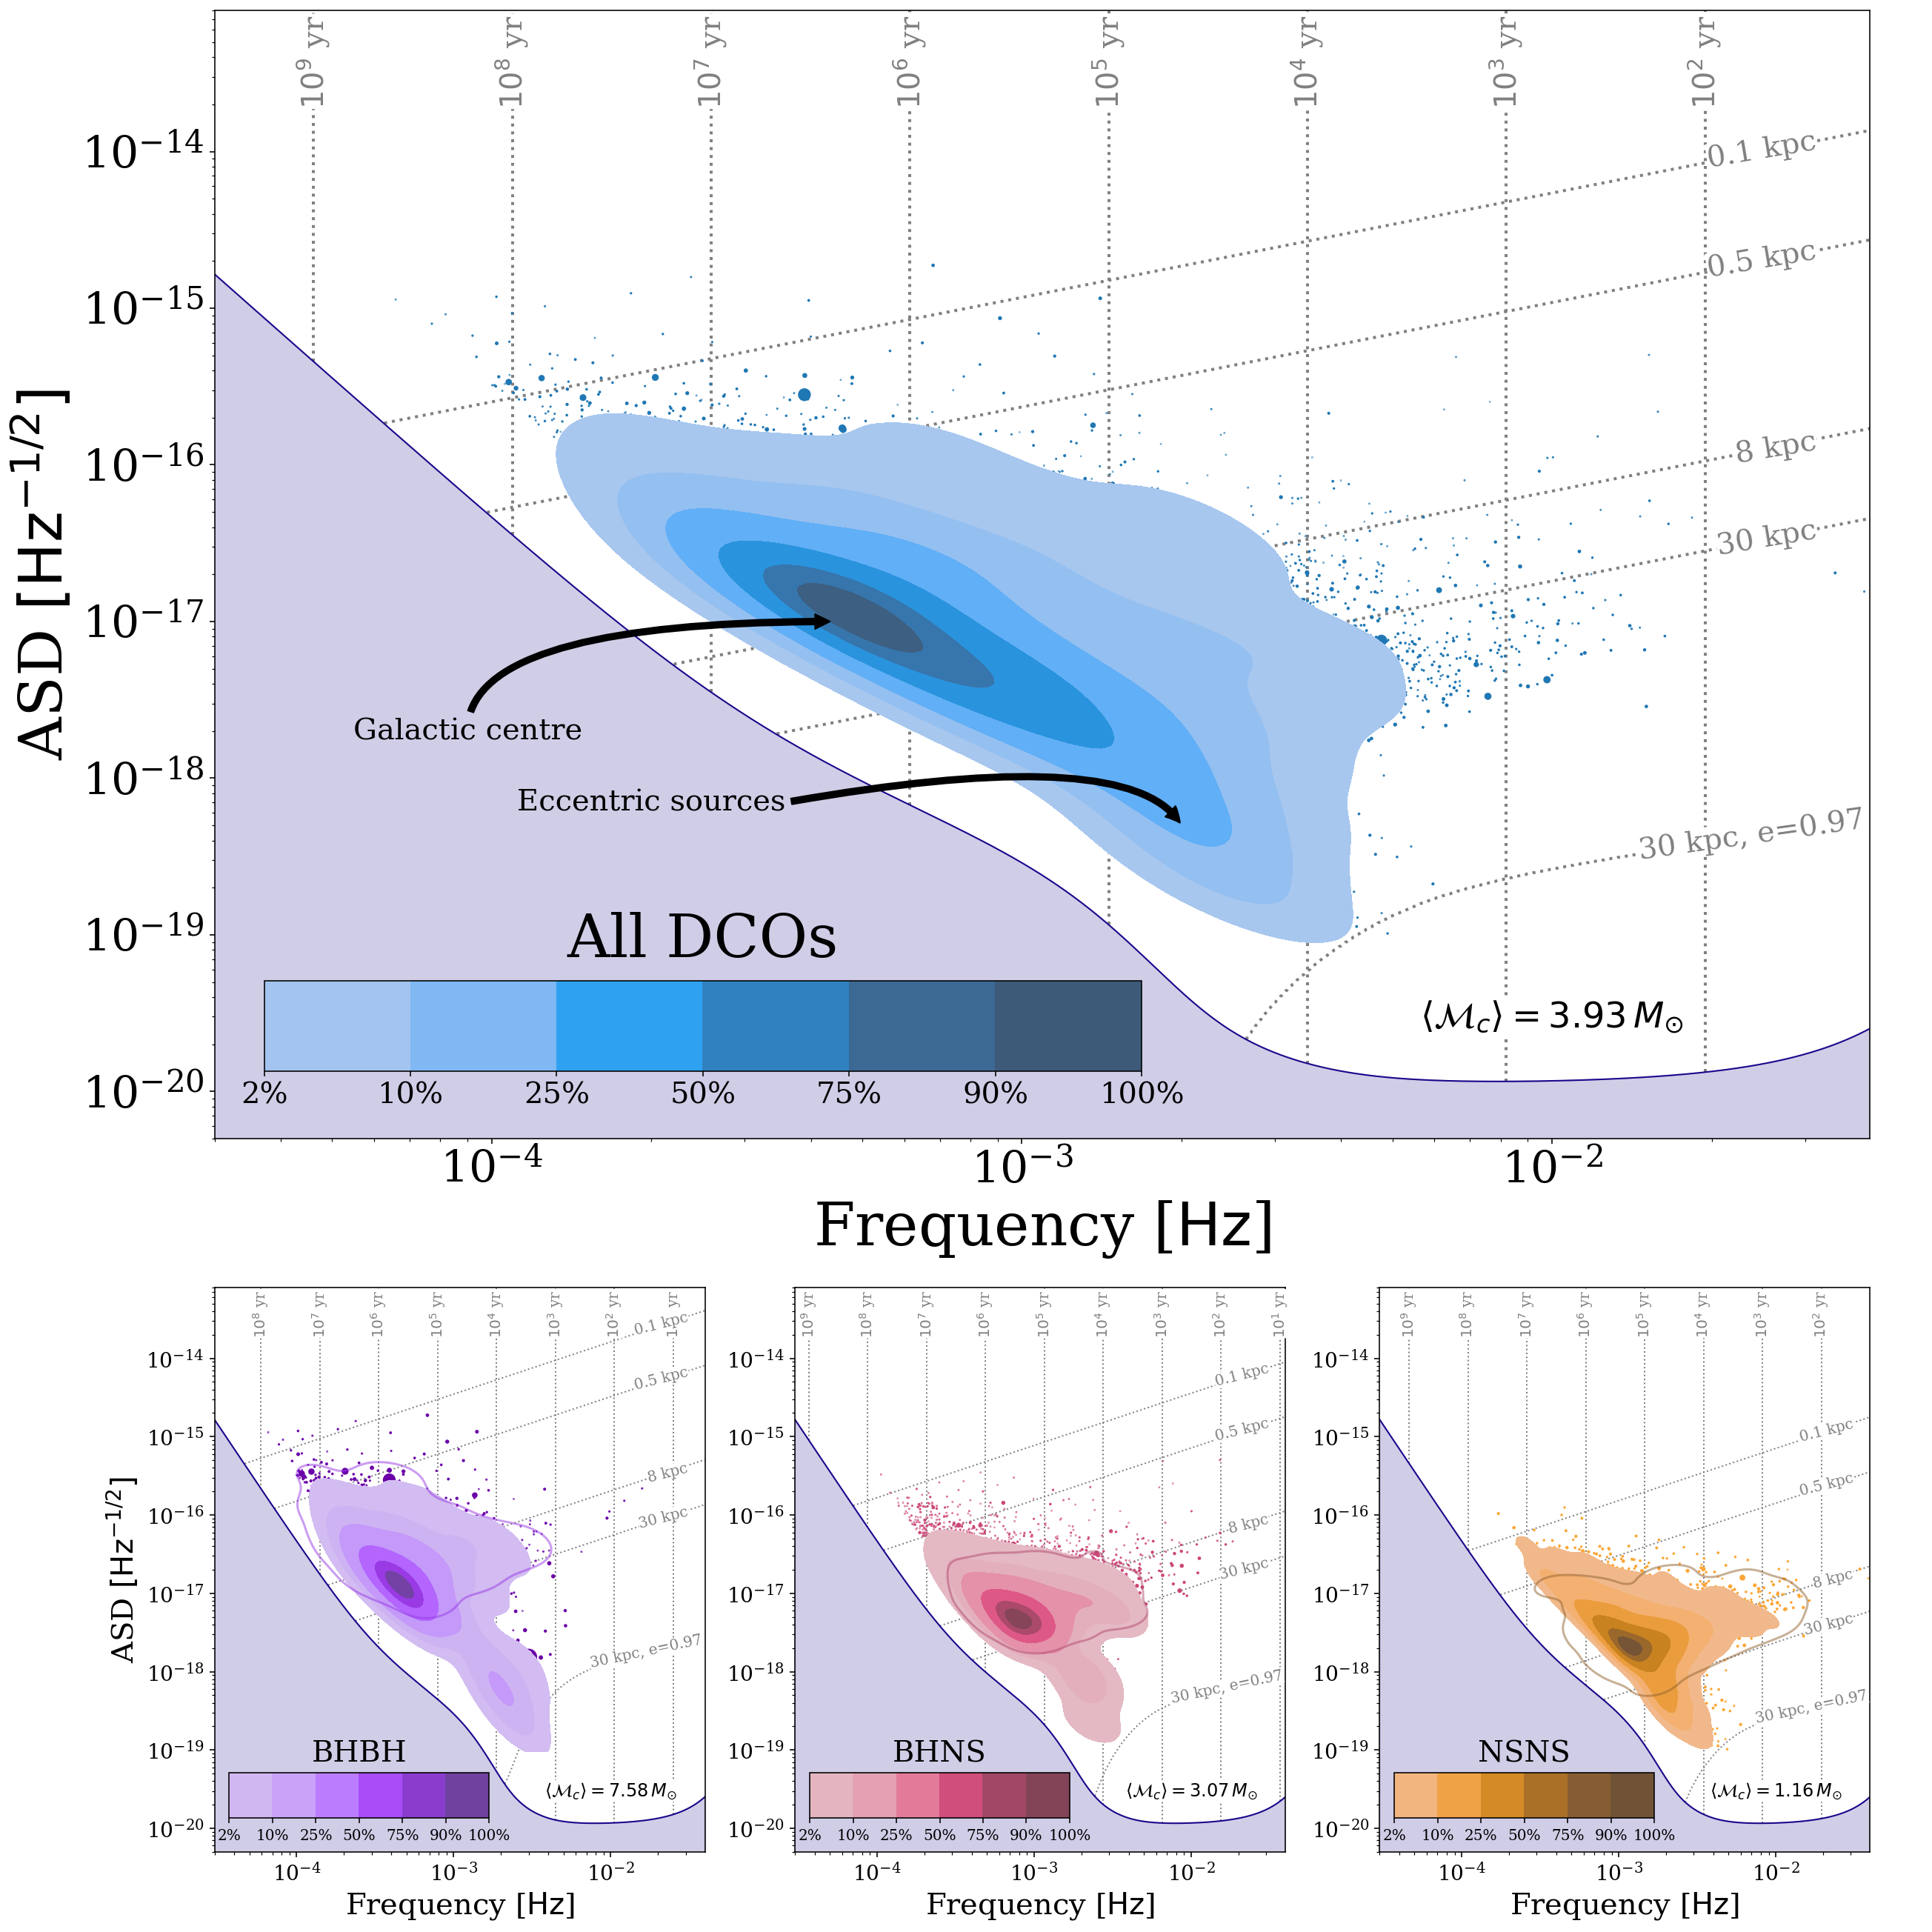

In [60]:
frequency_range = np.logspace(np.log10(3e-5), -1.4, 1000) * u.Hz

fig = plt.figure(figsize=(18, 18), constrained_layout=True)

gs = GridSpec(2, 3, figure=fig, height_ratios=(2, 1))
all_ax = fig.add_subplot(gs[0, :])
axes = [fig.add_subplot(gs[1, i]) for i in range(3)]
levels = [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]

all_mc_mean = np.mean([fid_sources[i].m_c.mean().value for i in range(len(fid_sources))]) * u.Msun
all_mc_min = np.min([fid_sources[i].m_c.min().value for i in range(len(fid_sources))]) * u.Msun
fig, all_ax = plot_sc_with_dist_lines(frequency_range, fig=fig, ax=all_ax,
                                      mc_mean=all_mc_mean,
                                      mc_min=all_mc_min,
                                      line_scale=2, line_rot=8, loc=-10)

all_f_dom = np.concatenate([fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic for i in range(len(fid_sources))])
all_snr = np.concatenate([fid_sources[i].snr for i in range(len(fid_sources))])
all_weight = np.concatenate([fid_sources[i].weight for i in range(len(fid_sources))])
all_ecc = np.concatenate([fid_sources[i].ecc for i in range(len(fid_sources))])

legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=all_f_dom, snr=all_snr, fig=fig, ax=all_ax,
                                                  show=False, color="tab:blue", s=all_weight * 25) #fid_sources[i].ecc

all_ax.annotate("Galactic centre",
                xy=(4.4e-4, 1e-17), xycoords='data',
                xytext=(9e-5, 2e-18), textcoords='data',
                arrowprops=dict(arrowstyle="simple", color="black",
                                connectionstyle="angle3,angleA=90,angleB=0"),
                fontsize=fs, ha="center", va="center")

all_ax.annotate("Eccentric sources",
                xy=(2e-3, 5e-19), xycoords='data',
                xytext=(2e-4, 7e-19), textcoords='data',
                arrowprops=dict(arrowstyle="simple", color="black",
                                connectionstyle="angle3,angleA=10,angleB=120", relpos=(1.0, 0.5)),
                fontsize=fs, ha="center", va="center")


# the lazy man's guide to colorbars: just plot hidden points
cmap = cmap_from_colour("tab:blue")
scatter = all_ax.scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
inset_all_ax = all_ax.inset_axes([0.03, 0.06, 0.53, 0.08])
cbar = fig.colorbar(scatter, ax=all_ax, cax=inset_all_ax, boundaries=levels, orientation="horizontal")
cbar.set_ticklabels(["2%", "10%", "25%", "50%", "75%", "90%", "100%"])
cbar.ax.tick_params(labelsize=fs)

all_ax.annotate("All DCOs", xy=(0.295, 0.15), xycoords="axes fraction", fontsize=2 * fs, color="black", ha="center", va="bottom")

legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=all_f_dom, snr=all_snr, fig=fig, ax=all_ax,
                                                  show=False, color="tab:blue", weights=all_weight,
                                                  disttype="kde", fill=True, levels=levels)

print("full done")

for i, dco_type in enumerate(dco_types):
    fig, axes[i] = plot_sc_with_dist_lines(frequency_range, fig=fig, ax=axes[i],
                                           mc_mean=fid_sources[i].m_c.mean(),
                                           mc_min=fid_sources[i].m_c.min(), line_rot=12, loc=-75)
    
    # the lazy man's guide to colorbars: just plot hidden points
    cmap = cmap_from_colour(dco_colours[dco_types[i]])
    scatter = axes[i].scatter(np.ones_like(levels) * 1e-5, np.ones_like(levels) * 1e-21, c=levels, cmap=cmap)
    inset_ax = axes[i].inset_axes([0.03, 0.06, 0.53, 0.08])
    cbar = fig.colorbar(scatter, ax=axes[i], cax=inset_ax, boundaries=levels, orientation="horizontal")
    cbar.set_ticklabels(["2%", "10%", "25%", "50%", "75%", "90%", "100%"])
    cbar.ax.tick_params(labelsize=10)
    
    f_dom = fid_sources[i].f_orb * fid_sources[i].max_snr_harmonic
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], s=fid_sources[i].weight * 25)
    
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom,
                                                      snr=fid_sources[i].snr, fig=fig, ax=axes[i], show=False,
                                                      color=dco_colours[dco_types[i]], weights=fid_sources[i].weight,
                                                      disttype="kde", fill=True, levels=levels)
    
    mask = fid_sources[i].ecc < 0.01
    color = list(cmap(0.75))
    color[-1] = 0.5
    legwork.visualisation.plot_sources_on_sc_ecc_stat(f_dom=f_dom[mask], snr=fid_sources[i].snr[mask],
                                                      fig=fig, ax=axes[i], show=False, color=tuple(color),
                                                      weights=fid_sources[i].weight[mask], disttype="kde",
                                                      fill=False, levels=[0.02],
                                                      bw_adjust=0.7 if i == 0 else 0.75 if i == 1 else 1.0)

    axes[i].annotate(dco_types[i], xy=(0.295, 0.15), xycoords="axes fraction",
                     fontsize=fs, color="black", ha="center", va="bottom")
    
    print(dco_types[i], "done")

ylims = (5e-21, 8e-14)
    
for ax in [all_ax] + axes:
    if ax in axes[1:]:
        ax.set_ylabel("")
    ax.set_ylim(ylims)
    
all_ax.tick_params(labelsize=1.5 * fs)
all_ax.xaxis.label.set_fontsize(2 * fs)
all_ax.yaxis.label.set_fontsize(2 * fs)

# plt.savefig("../../paper/figures/dcos_on_sc.png", dpi=300, bbox_inches="tight")
# plt.savefig("../../paper/figures/dcos_on_sc_high_res.png", dpi=600, bbox_inches="tight")

# plt.savefig("../../paper/figures/dcos_on_sc.png_alt", dpi=300, bbox_inches="tight")
# plt.savefig("../../paper/figures/dcos_on_sc_high_res_alt.png", dpi=600, bbox_inches="tight")

plt.show()